In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import pathlib
import numpy as np
import pandas as pd
import html
import re
from fastai.text import *

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

LANG = 'id'
PATH_ROOT = Path(f'lmdata/{LANG}')
PATH_DATASET = Path(f'{PATH_ROOT}/dataset/BPPTIndToEngCorpus')
PATH_MODELS = Path(f'{PATH_ROOT}/models/')
PATH_TMP = Path(f'{PATH_ROOT}/tmp/')
np.random.seed(42)

In [4]:
LANG_FILENAMES = [str(f) for f in PATH_DATASET.rglob("*-ID-*.txt")]
print(len(LANG_FILENAMES))
LANG_FILENAMES

4


['lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-ECO-ID-150Kw.txt',
 'lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-INT-ID-150Kw.txt',
 'lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-SCI-ID-100Kw.txt',
 'lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-SPO-ID-100Kw.txt']

In [5]:
CLASSES = {v:i for i,v in enumerate(['ECO', 'INT', 'SCI', 'SPO'])}
LANG_TEXT = []
for fn in tqdm(LANG_FILENAMES):
    CLASSNAME = re.sub('.+-([A-Z]+)-ID.+', r'\1', fn)
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append((CLASSES[CLASSNAME], line.rstrip()))

df = pd.DataFrame.from_records(LANG_TEXT, columns=['label', 'text'])
df.head()

100%|██████████| 4/4 [00:00<00:00, 170.78it/s]


,label,text
0,0,Menteri Keuangan Sri Mulyani mengatakan koreks...
1,0,Dalam jumpa pers bersama Dirut Bursa Efek Jaka...
2,0,Kita melihat faktor inflasi dari makanan akan ...
3,0,Demikian pula dengan harga minyak.
4,0,"Kondisi APBN 2007 pada dua pekan awal, secara ..."


In [6]:
df.to_csv(f"{PATH_DATASET}/bppt_panl.csv", header=False, index=False)

In [7]:
df = pd.read_csv(f"{PATH_DATASET}/bppt_panl.csv")
df.columns = ['label', 'text']

In [8]:
df.head()

,label,text
0,0,Dalam jumpa pers bersama Dirut Bursa Efek Jaka...
1,0,Kita melihat faktor inflasi dari makanan akan ...
2,0,Demikian pula dengan harga minyak.
3,0,"Kondisi APBN 2007 pada dua pekan awal, secara ..."
4,0,"Menurut data Depkeu, net buy obligasi negara a..."


In [9]:
trn_texts, val_texts = sklearn.model_selection.train_test_split(
    df, test_size=0.1, random_state=1) # split the data into train and validation sets

In [10]:
trn_texts[:5]

,label,text
12489,1,"Saya berada di sini dua tahun lalu, tapi saat ..."
1604,0,Pertumbuhan ekonomi 2007 yang diproyeksikan me...
19548,3,Pelatih Real Bernd Schuster harus mengeluarkan...
15680,2,Laporan itu adalah pengumuman kedua dari badan...
2780,0,"Lonjakan laba bersih tersebut, selain didorong..."


In [11]:
trn_texts.to_csv(f"{PATH_DATASET}/bppt_panl_train.csv", header=False, index=False)
val_texts.to_csv(f"{PATH_DATASET}/bppt_panl_test.csv", header=False, index=False)

In [12]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [13]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [14]:
chunksize = 10000
df_trn = pd.read_csv(f"{PATH_DATASET}/bppt_panl_train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(f"{PATH_DATASET}/bppt_panl_test.csv", header=None, chunksize=chunksize)

In [15]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
0


In [16]:
tok_trn[:2]

[['\n',
  'xbos',
  'xfld',
  '1',
  'saya',
  'berada',
  'di',
  'sini',
  'dua',
  'tahun',
  'lalu',
  ',',
  'tapi',
  'saat',
  'ini',
  'terdapat',
  'lebih',
  'banyak',
  'makanan',
  'gratis',
  'dan',
  'tak',
  'ada',
  'keributan',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'pertumbuhan',
  'ekonomi',
  '2007',
  'yang',
  'diproyeksikan',
  'mencapai',
  '6,3',
  'persen',
  ',',
  'merupakan',
  'tantangan',
  'berat',
  'meski',
  'sampai',
  'dengan',
  'hari',
  'ini',
  'hampir',
  'semua',
  'kalangan',
  'berpendapat',
  'realitas',
  'pertumbuhan',
  'realitas',
  'mencapai',
  'sekitar',
  '6,1',
  'persen',
  '.']]

In [17]:
# create a tmp directory to store the upcoming numpy arrays
(PATH_TMP).mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(PATH_TMP/'tok_trn.npy', tok_trn)
np.save(PATH_TMP/'tok_val.npy', tok_val)

In [18]:
tok_trn = np.load(PATH_ROOT/'tmp'/'tok_trn.npy')
tok_val = np.load(PATH_ROOT/'tmp'/'tok_val.npy')

In [19]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 26503),
 ('1', 22182),
 ('.', 21637),
 ('\n', 21620),
 ('xbos', 21620),
 ('xfld', 21620),
 ('yang', 12838),
 ('dan', 9496),
 ('di', 8706),
 ('-', 6737),
 ('pada', 5305),
 ('dari', 4999),
 ('dengan', 4884),
 ('itu', 4723),
 ('t_up', 4719),
 ('untuk', 4610),
 ('dalam', 4373),
 ('ini', 3800),
 ('akan', 3147),
 ('tersebut', 2374),
 ('tidak', 2352),
 ('mereka', 2182),
 ('kata', 2153),
 ('persen', 2151),
 ('tahun', 2077)]

In [20]:
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') #

In [21]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

6813

In [22]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [23]:
trn_lm[:2]

array([list([5, 6, 7, 3, 45, 142, 10, 737, 52, 26, 60, 2, 248, 55, 19, 605, 33, 124, 673, 2907, 9, 116, 67, 0, 4]),
       list([5, 6, 7, 3, 148, 98, 71, 8, 4113, 70, 1455, 25, 2, 78, 1952, 481, 389, 181, 14, 88, 19, 476, 196, 883, 2795, 0, 148, 0, 70, 105, 3029, 25, 4])],
      dtype=object)

In [24]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(PATH_TMP/'trn_ids.npy', trn_lm)
np.save(PATH_TMP/'val_ids.npy', val_lm)
pickle.dump(itos, open(PATH_MODELS/'bppt_panl_itos.pkl', 'wb'))

In [25]:
trn_lm = np.load(PATH_TMP/'trn_ids.npy')
val_lm = np.load(PATH_TMP/'val_ids.npy')
itos = pickle.load(open(PATH_MODELS/'bppt_panl_itos.pkl', 'rb'))

In [26]:
vs=len(itos)
vs,len(trn_lm)

(6813, 21620)

In [27]:
em_sz,nh,nl = 400,1150,3

In [28]:
PRE_LM_PATH = PATH_MODELS/'wiki_id_lm.h5'

In [29]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [30]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [31]:
itos2 = pickle.load((PATH_ROOT/'wiki_id_itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [32]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [33]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [34]:
wd=1e-7
bptt=70
bs=100
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)
weight_factor = 0.1

In [35]:
bs=100

In [36]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH_MODELS, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [37]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*weight_factor

In [38]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [39]:
learner.model.load_state_dict(wgts)

In [40]:
# AWD-LSTM network
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(6813, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(6813, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=6813, bias=False)
    (dropout): LockedDropout(
    )
  )
)>

In [41]:
lr=1e-3
lrs = lr

In [42]:
%time 

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


epoch      trn_loss   val_loss   accuracy                 
    0      4.982801   4.937512   0.233285  



[array([4.93751]), 0.23328453116118908]

In [43]:
learner.save('lm_last_ft')

In [44]:
learner.load('lm_last_ft')

In [45]:
learner.unfreeze()

In [46]:
%time

learner.lr_find2(num_it=1000)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


 76%|███████▋  | 65/85 [00:17<00:05,  3.74it/s, loss=3.57]

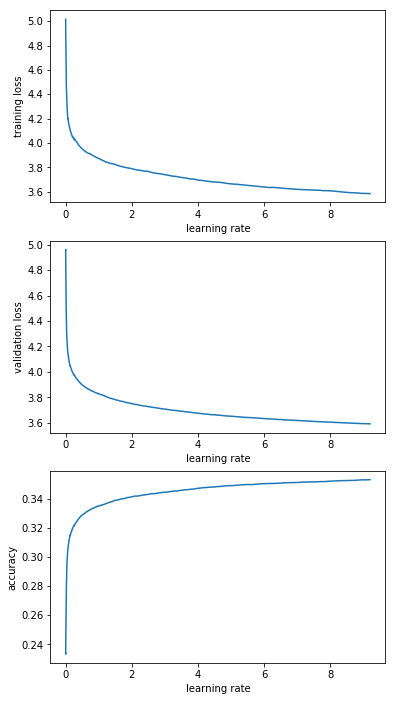

In [47]:
learner.sched.plot()

In [48]:
# Set learning rate
lr = 0.2

In [49]:
%time

learner.fit(lr, 1, wds=wd, cycle_len=50, use_clr=(10,33,0.95,0.85), best_save_name='best_lm_indonesia_1cycle_bppt_panl')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


epoch      trn_loss   val_loss   accuracy                 
    0      4.157194   3.935868   0.324718  
    1      3.941628   3.837137   0.333785                 
    2      3.854142   3.789139   0.337888                 
    3      3.801619   3.756119   0.34124                  
    4      3.767735   3.72448    0.344196                 
    5      3.740551   3.711374   0.344649                 
    6      3.71324    3.680391   0.348372                 
    7      3.690399   3.67833    0.347471                 
    8      3.670641   3.660356   0.349618                 
    9      3.653356   3.650381   0.349958                 
    10     3.633217   3.641808   0.350328                 
    11     3.618268   3.631516   0.351111                 
    12     3.604605   3.620367   0.352371                 
    13     3.591901   3.614837   0.352316                 
    14     3.576696   3.607112   0.35274                  
    15     3.56662    3.594448   0.354158                 
    16     3

[array([3.49003]), 0.3648568019270897]

In [49]:
%time

learner.fit(lr, 1, wds=wd, cycle_len=50, use_clr=(10,33,0.95,0.85), best_save_name='best_lm_indonesia_1cycle_bppt_panl')

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 5.48 µs


epoch      trn_loss   val_loss   accuracy                 
    0      4.133721   3.956492   0.324278  
    1      3.93578    3.839863   0.333573                 
    2      3.843437   3.785825   0.338499                 
    3      3.784889   3.747476   0.341664                 
    4      3.743502   3.712742   0.345656                 
    5      3.711029   3.696667   0.345959                 
    6      3.680475   3.66531    0.34953                  
    7      3.655367   3.660157   0.349525                 
    8      3.630483   3.639064   0.35176                  
    9      3.608957   3.630309   0.352317                 
    10     3.588673   3.620427   0.353047                 
    11     3.570759   3.609911   0.354204                 
    12     3.55254    3.598645   0.354862                 
    13     3.537018   3.591663   0.35574                  
    14     3.519699   3.583402   0.356536                 
    15     3.508309   3.570674   0.358058                 
    16     3

[array([3.47393]), 0.3668234758079052]

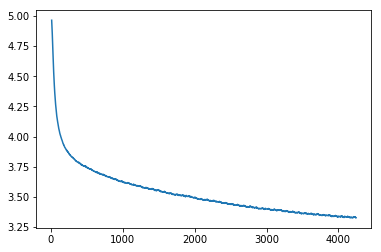

In [50]:
learner.sched.plot_loss()

In [51]:
#learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [52]:
#learner.sched.plot()

In [53]:
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

In [51]:
learner.save('lm1')
learner.save_encoder('lm1_enc')

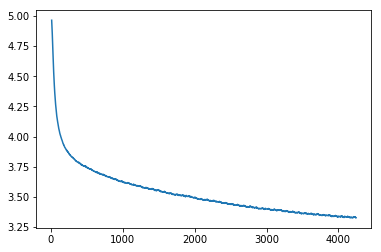

In [52]:
learner.sched.plot_loss()

## Classifier tokens


In [53]:
chunksize = 10000
df_trn = pd.read_csv(f"{PATH_DATASET}/bppt_panl_train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(f"{PATH_DATASET}/bppt_panl_test.csv", header=None, chunksize=chunksize)

In [54]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
0


In [55]:
(PATH_TMP).mkdir(exist_ok=True)

np.save(PATH_TMP/'bppt_panl_tok_trn.npy', tok_trn)
np.save(PATH_TMP/'bppt_panl_tok_val.npy', tok_val)

np.save(PATH_TMP/'bppt_panl_trn_labels.npy', trn_labels)
np.save(PATH_TMP/'bppt_panl_val_labels.npy', val_labels)

In [56]:
tok_trn = np.load(PATH_TMP/'bppt_panl_tok_trn.npy')
tok_val = np.load(PATH_TMP/'bppt_panl_tok_val.npy')

In [57]:
itos = pickle.load((PATH_MODELS/'bppt_panl_itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

6813

In [58]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [59]:
np.save(PATH_TMP/'bppt_panl_trn_ids.npy', trn_clas)
np.save(PATH_TMP/'bppt_panl_val_ids.npy', val_clas)

## Classifier

In [60]:
trn_clas = np.load(PATH_TMP/'bppt_panl_trn_ids.npy')
val_clas = np.load(PATH_TMP/'bppt_panl_val_ids.npy')

In [61]:
trn_labels = np.squeeze(np.load(PATH_TMP/'bppt_panl_trn_labels.npy'))
val_labels = np.squeeze(np.load(PATH_TMP/'bppt_panl_val_labels.npy'))

In [62]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48
weight_factor = 0.8

In [63]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [64]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH_MODELS, trn_dl, val_dl)

In [65]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [66]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*weight_factor

In [67]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [68]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [69]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [70]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [71]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [72]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [73]:
learn.freeze_to(-1)

 78%|███████▊  | 704/901 [00:13<00:03, 53.68it/s, loss=1.9]  

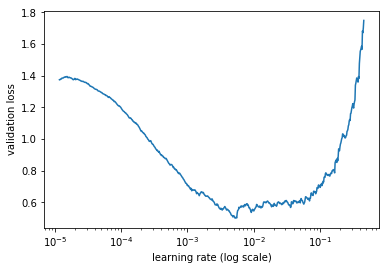

In [74]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [75]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.509603   0.237185   0.916355  


[array([0.23719]), 0.9163545564319311]

In [76]:
learn.save('clas_0')

In [77]:
learn.load('clas_0')

In [78]:
learn.freeze_to(-2)

In [79]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.407381   0.205364   0.928423  


[array([0.20536]), 0.9284228084239174]

In [80]:
learn.save('clas_1')

In [81]:
learn.load('clas_1')

In [82]:
learn.unfreeze()

In [83]:
%time

learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(32,10))

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs


epoch      trn_loss   val_loss   accuracy                    
    0      0.399376   0.223006   0.92551   
    1      0.351069   0.212735   0.929671                    
    2      0.308267   0.201409   0.93841                     
    3      0.26033    0.177268   0.943404                    
    4      0.255846   0.181364   0.940491                    
    5      0.209574   0.170326   0.947566                    
    6      0.242916   0.16978    0.944236                    
    7      0.197913   0.173062   0.945901                    
    8      0.156588   0.164498   0.951727                    
    9      0.186398   0.160765   0.952559                    
    10     0.176702   0.163246   0.950479                    
    11     0.162039   0.173846   0.953392                    
    12     0.179223   0.162937   0.953392                    
    13     0.151864   0.167528   0.955472                    
    14     0.178218   0.165271   0.954224                    
    15     0.170336   0.16

[array([0.16112]), 0.9563046239883861]

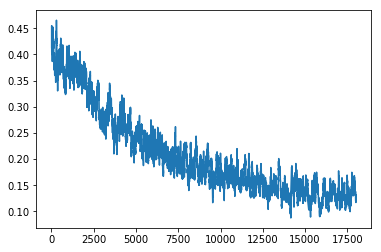

In [84]:
learn.sched.plot_loss()

In [85]:
learn.save('clas_2')